### Benchmarking studies on trying to train neural networks using MPI
#### Worked by: Silvana Belegu

##### Basic implementation

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad

In [26]:
def load_data(file_path):
    # Load the MNIST dataset from an .npz file
    file_path = "mnist.npz"  # Replace with your file's path
    mnist_data = np.load(file_path)

    # Extract train and test sets
    x_train = mnist_data['x_train']
    y_train = mnist_data['y_train']
    x_test = mnist_data['x_test']
    y_test = mnist_data['y_test']

    return (x_train, y_train), (x_test, y_test)

In [27]:
(x_train, y_train), (x_test, y_test) = load_data('mnist.npz')
x = x_train[0]
y_true = x.copy()


In [28]:
# Add salt-and-pepper noise
num_corrupted_pixels = 100
for _ in range(num_corrupted_pixels):
    i, j = np.random.randint(0, x.shape[0]), np.random.randint(0, x.shape[1])
    x[i, j] = np.random.choice([0, 255])

In [29]:
# Normalize images
y_true = y_true.astype(np.float32) / 255.0
x = x.astype(np.float32) / 255.0

In [30]:
# Define convolution function using JAX
def convolution_2d(x, kernel):
    input_height, input_width = x.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2

    # Pad the input array by adding extra pixel
    padded_x = jnp.pad(x, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Initialize the output matrix
    output_data = jnp.zeros_like(x)

    # Perform the convolution operation
    for i in range(input_height):
        for j in range(input_width):
            # Extract the region of interest
            region = padded_x[i:i + kernel_height, j:j + kernel_width]
            # Perform element-wise multiplication and summation
            output_data = output_data.at[i, j].set(jnp.sum(region * kernel))
            # Equivalent to : output_data[i, j] = jnp.sum(region * kernel)

    return output_data


In [31]:
# Define loss function
def loss_fn(kernel, x, y_true):
    y_pred = convolution_2d(x, kernel)
    return jnp.mean((y_pred - y_true) ** 2)  # Mean squared error


In [32]:
# Initialize kernel
kernel = jnp.array([[0.01, 0.0, 0.0],
                    [-1.0, 0.0, 1.0],
                    [0.0, 0.0, 0.0]])  # Random kernel for horizontal edge detection


In [33]:
# Gradient of the loss function w.r.t. the kernel
loss_grad = grad(loss_fn)

# Training loop
learning_rate = 0.01
num_iterations = 10

In [34]:
losses = []
for i in range(num_iterations):
    gradients = loss_grad(kernel, x, y_true)
    kernel -= learning_rate * gradients  # Update kernel with gradient descent

    # Compute and store the loss
    current_loss = loss_fn(kernel, x, y_true)
    losses.append(current_loss)

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {current_loss:.4f}")


Iteration 0, Loss: 0.2696


In [35]:
# Visualize results
plt.figure(figsize=(8, 6))


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Text(0, 0.5, 'Loss')

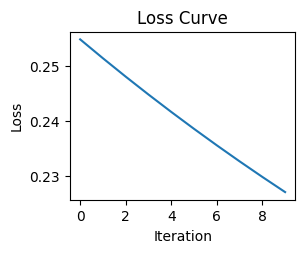

In [ ]:
# Plot loss over iterations
plt.subplot(2, 2, 1)
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

(-0.5, 27.5, 27.5, -0.5)

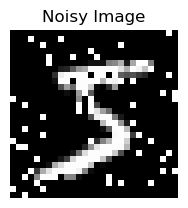

In [36]:
# Display original noisy image
plt.subplot(2, 2, 2)
plt.imshow(x, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

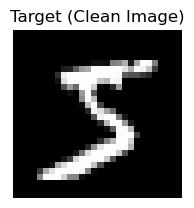

In [37]:
# Display target clean image
plt.subplot(2, 2, 3)
plt.imshow(y_true, cmap='gray')
plt.title("Target (Clean Image)")
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

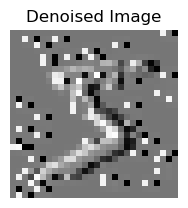

In [38]:
# Display denoised image
y_denoised = convolution_2d(x, kernel)
plt.subplot(2, 2, 4)
plt.imshow(y_denoised, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

In [39]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Multi-core training

To do the multi-core training and perform benchmark studies to measure execution time and cpu time, I have used `train_benchmark.py` and `run_benchmark.sh`. The results are interpreted below. 

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# Load the benchmark data
data = {
    "Processes": [1, 2, 4, 8, 10],
    "Average Execution Time (s)": [17.7104, 9.2809, 4.7267, 3.9685, 4.9759]
}


In [46]:
# Create a DataFrame
df = pd.DataFrame(data)

# Calculate Speedup (optional for deeper analysis)
df["Speedup (Execution)"] = df["Average Execution Time (s)"].iloc[0] / df["Average Execution Time (s)"]

# Display the DataFrame
print(df)



   Processes  Average Execution Time (s)  Speedup (Execution)
0          1                     17.7104             1.000000
1          2                      9.2809             1.908263
2          4                      4.7267             3.746885
3          8                      3.9685             4.462744
4         10                      4.9759             3.559236


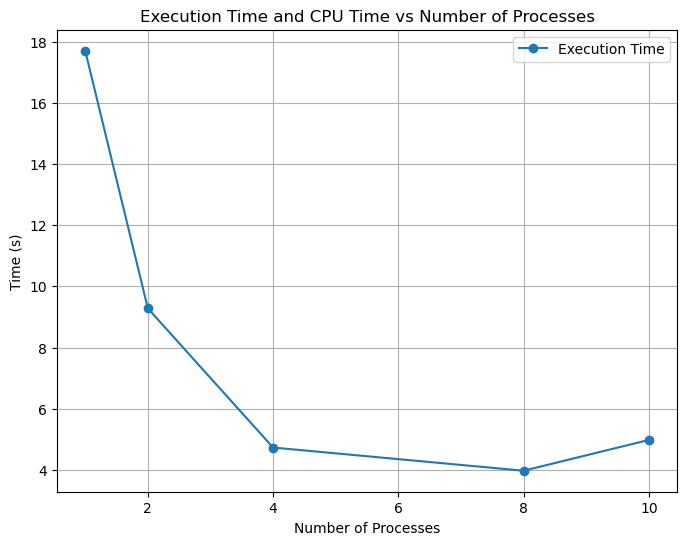

In [50]:
# Plot the results
# Execution Time
plt.figure(figsize=(8, 6))
plt.plot(df["Processes"], df["Average Execution Time (s)"], marker='o', label="Execution Time")
plt.xlabel("Number of Processes")
plt.ylabel("Time (s)")
plt.title("Execution Time and CPU Time vs Number of Processes")
plt.legend()
plt.grid(True)
plt.show()



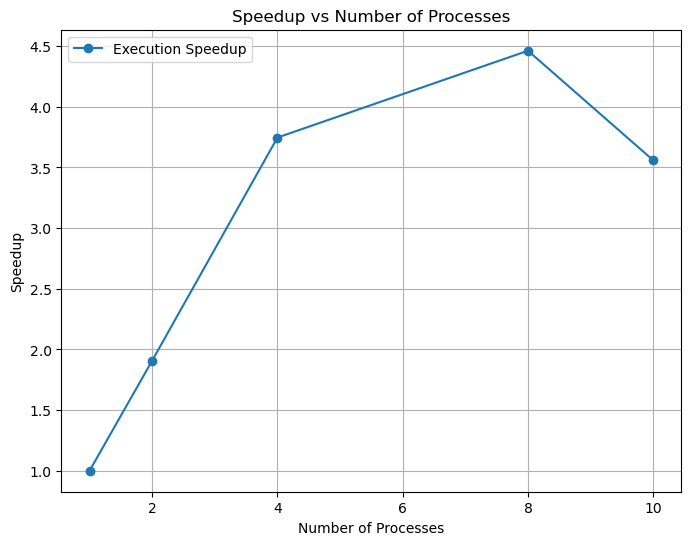

In [49]:
# Speedup
plt.figure(figsize=(8, 6))
plt.plot(df["Processes"], df["Speedup (Execution)"], marker='o', label="Execution Speedup")
plt.xlabel("Number of Processes")
plt.ylabel("Speedup")
plt.title("Speedup vs Number of Processes")
plt.legend()
plt.grid(True)
plt.show()


What can be seen from the results is that the execution time and the speedup improve as long as the number of processes is equal to the number of cores that has been used. The number of cores that were allocated in total is 8, so when the number of processes is 10, the cores become oversubscribed and the performance decreases.